# Orangutan Organoid Scanpy

~15000 Cells from a 10x run. Basic analysis along with trying out my new implementation of RNA velocity analysis. This includes:
Filtering, normalizing, dimension reduction, louvain clustering, DE, gene set scoring, and RNA velocity.

In [2]:
%matplotlib inline

import matplotlib
#matplotlib.use('agg') # plotting backend compatible with screen
import scanpy
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging as logg
import os
import loompy
import scipy
import re
import anndata
import random
import sklearn
import importlib.util
spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("~/code/pollye/MTsc/utils/ScanpyUtilsMT.py"))
sc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sc_utils)


results_file = os.path.expanduser('~/Desktop//home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/processedOrangutanOrganoidScanpy.h5ad')

/home/mt/code/pollye/MTsc/utils/ScanpyUtilsMT.py:11: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/mt/code/utils/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mt/code/utils/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", lin

In [9]:
adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/orangutanorganoid_Pabe3_20180719_S10_Out/outs/raw_gene_bc_matrices_h5.h5','refdata-cellranger-Pabe3_20180719')

#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
sc.tl.addCleanObsNames(adata)
adata.var_names_make_unique()

mito_genes = [name for name in adata.var_names if name.startswith(('MTND','MTCO','MTATP','MTCYB','MTRNR','MTTR',))]
ribo_genes = [name for name in adata.var_names if name.startswith('RPS') or name.startswith('RPL') ]

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['percent_ribo'] = np.sum(
    adata[:, ribo_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
#scanpy.api.pp.filter_genes_dispersion(adata,n_top_genes=np.sum(np.sum(adata.X, axis=0)>0))
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_cells(adata,min_counts=800)
adata=adata[adata.obs.n_counts.argsort(),:]

#sc.pp.filter_cells(adata, min_counts=10)
#adata=adata[random.sample(k=10000,population=set(adata.obs.index)),:]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [10]:
adata

View of AnnData object with n_obs × n_vars = 2264 × 9900 
    obs: 'clean_obs_names', 'percent_mito', 'percent_ribo', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [26]:
print(np.sum(np.sum(adata[adata.obs.n_counts<=200,:].X,axis=0)))
print(np.sum(np.sum(adata[adata.obs.n_counts>600,:].X,axis=0)))

2093635.0
4480184.0


In [27]:
wt_prior=np.zeros((2,adata.shape[1]))
wt_prior[0,:]=np.sum(adata[adata.obs.n_counts<100,:].X,axis=0)
wt_prior+=.1
wt_prior.shape
#dt_prior=np.zeros((10,))
#dt_prior+=1
#dt_prior[0]=1
dt_prior=1

In [28]:
wt_prior.shape

(2, 10747)

In [29]:
adata=adata[adata.obs.n_counts>80,:]

In [34]:
import gensim
import itertools
def get_doc_topic(corpus, model,eps=0.0):
    doc_topic = list()
    for doc in corpus:
        doc_topic.append(model.__getitem__(doc, eps=eps))
        #Convert index,value tuples to sparse matrix, then dense
    ii=[[i]*len(v) for i,v in enumerate(doc_topic)]
    ii=list(itertools.chain(*ii))
    jj=[j for j,_ in itertools.chain(*doc_topic)]
    data=[d for _,d in itertools.chain(*doc_topic)]
    return(scipy.sparse.csr_matrix((data, (ii, jj))).todense(),list(set(jj)))


def get_topic_to_wordids(model,eps=0.0):
    p = list()
    if hasattr(model, 'm_T'):
        for topicid in range(model.m_T):
            topic = model.m_lambda[topicid]
            topic = topic / topic.sum() # normalize to probability dist
            p.append(topic)
        return(np.array(p).T,list(range(model.m_T)))
    else:
        for topicid in range(model.num_terms):
            topic = model.get_term_topics(topicid,minimum_probability=eps)
            p.append(topic)
        ii=[[i]*len(v) for i,v in enumerate(p)]
        ii=list(itertools.chain(*ii))
        jj=[j for j,_ in itertools.chain(*p)]
        data=[d for _,d in itertools.chain(*p)]
        return(scipy.sparse.csr_matrix((data, (ii, jj))).todense(),list(set(jj)))


adata=adata[:,adata.var.index.argsort()]
model = gensim.models.LdaModel(corpus=gensim.matutils.Sparse2Corpus( adata[20000:,:].X.T),passes=1,id2word=gensim.corpora.dictionary.Dictionary([adata.var.index.tolist()]),num_topics=2,alpha=1,eta=1)
doc_topic,included=get_doc_topic(gensim.matutils.Sparse2Corpus(adata.X.T),model)

adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(10747 unique tokens: ['A1BG', 'A2M', 'AAAS', 'AACS', 'AADAT']...) from 1 documents (total 10747 corpus positions)
using serial LDA version on this node
running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 5658 documents, updating model once every 2000 documents, evaluating perplexity every 5658 documents, iterating 50x with a convergence threshold of 0.001000
too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
PROGRESS: pass 0, at document #2000/5658
merging changes from 2000 documents into a model of 5658 documents
topic #0 (1.000): 0.102*"MALAT1" + 0.024*"RPL7" + 0.022*"RPS27" + 0.020*"RPL21" + 0.017*"RPL34" + 0.015*"RPL39" + 0.015*"RPS19" + 0.011*"RPS3A" + 0.011*"RPL41" + 0.010*"RPL32"
topic #1 (1.000): 0.148*"MALAT1" + 0.019*"RPL39" + 0.018*"RPL34" + 0.018*"RPS27" + 0.018*"RPL7" + 0.016*"RPS19" + 0.014*"RPL2

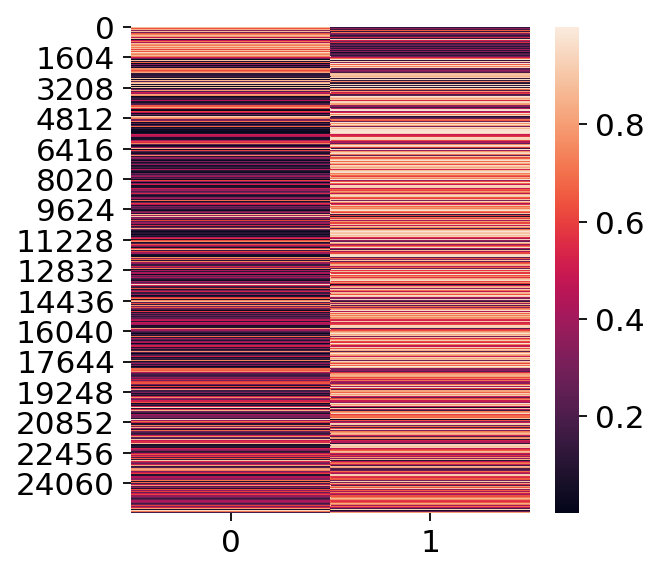

In [35]:
import seaborn
seaborn.heatmap(doc_topic)#/np.max(doc_topic,axis=0))

In [47]:
word_topic,included=get_topic_to_wordids(model)
print(np.argsort(word_topic[:,0].A1-word_topic[:,1].A1))

[4612 7796 6540 ... 7733 7807 9773]


In [50]:
adata.var.index[np.argsort(word_topic[:,0].A1-word_topic[:,1].A1)]
adata.var.index[np.argsort(wt_prior[:,0]-word_topic[:,1].A1)]



ValueError: operands could not be broadcast together with shapes (2,) (10747,) 

In [39]:
#print(doc_topic[:,5])
#print(word_topic[:,5])
#print(adata.obs.n_counts)
print(np.matrix(word_topic[:,0]).T.shape)
print(np.matrix(wt_prior[0,:]).shape)
np.corrcoef(np.matrix(word_topic[:,0]).T,np.matrix(wt_prior[0,:]))
np.corrcoef(np.matrix(word_topic[:,0]).T,np.matrix(word_topic[:,1]).T)

(1, 10747)
(1, 10747)


array([[1.        , 0.95020998],
       [0.95020998, 1.        ]])

In [173]:
adata[0,:].X
#print(word_topic[:,0])
#print(doc_topic[0,:])
#print(sum(adata[0,:].X)*word_topic[:,0])

#print('Number of reads that should be assigned to each topic')
#print(sum(adata[0,:].X)*doc_topic[0,:])
#print(np.diag((sum(adata[0,:].X)*doc_topic[0,:]).A1))
#print(np.diag((sum(adata[0,:].X)*doc_topic[0,:])[0]))

q=adata[0,:].X*np.diag(doc_topic[0,:])*word_topic[:,0].T
print(q.shape)
print(np.sum(q,axis=0))
print(np.sum(q,axis=1))
print(doc_topic[0,:])
print(np.sum(np.sum(q/np.sum(q,axis=1),axis=0)))

m = word_topic*np.diag((sum(adata[0,:].X)*doc_topic[0,:]).A1)
m = word_topic*adata[0,:].X*np.diag((sum(adata[0,:].X)*doc_topic[0,:]).A1)
m = m[:,:]
print(np.sum(m,axis=0))
#print(np.sum(m,axis=1))


(1, 10747)
[[0. 0. 0. ... 0. 0. 0.]]
[[2.6780184e-05]]
[[0.00874372 0.08776903 0.03445705 0.10244524 0.21329597 0.06251406
  0.04447614 0.14661895 0.07224915 0.22743069]]
1.0


ValueError: shapes (10747,10) and (1,10747) not aligned: 10 (dim 1) != 1 (dim 0)

In [136]:
print(adata[0,:].X.shape)
print(adata[0,:].X)
print(word_topic.shape)
print(word_topic)
print(sum(adata[0,:].X))
print(sum(adata[0,:].X))
print(doc_topic[0,:].shape)
print(doc_topic[0,:])

(10747,)
[0. 0. 0. ... 0. 0. 0.]
(10747, 10)
[[1.6590617e-04 0.0000000e+00 0.0000000e+00 ... 9.4873449e-06
  0.0000000e+00 5.0674288e-07]
 [9.8993942e-06 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  9.7101132e-05 0.0000000e+00]
 [5.0308404e-06 3.1339321e-05 1.8773679e-05 ... 9.4475454e-06
  3.1939853e-05 2.2966044e-05]
 ...
 [5.6225458e-06 1.2280586e-08 4.0589625e-06 ... 1.5120045e-05
  1.1566464e-06 9.3062927e-06]
 [7.0231268e-05 1.7075552e-06 0.0000000e+00 ... 2.9091541e-06
  2.8047559e-08 0.0000000e+00]
 [2.3672388e-05 1.4120783e-05 0.0000000e+00 ... 8.8774168e-06
  3.8946845e-07 5.1871962e-06]]
90.0
90.0
(1, 10)
[[0.00874372 0.08776903 0.03445705 0.10244524 0.21329597 0.06251406
  0.04447614 0.14661895 0.07224915 0.22743069]]


In [27]:
newX=[]
for i in range(adata.shape[0]):
    print(i)
    q=np.multiply(np.matrix(adata[i,:].X)*doc_topic[i,0],np.matrix(word_topic[:,0]).T)
    newX.append((adata[i,:].X-q/np.sum(q)*doc_topic[i,0]).A1)
scipy.sparse.csr_matrix(np.array(newX))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


KeyboardInterrupt: 

In [28]:
i=1
print(newX)
#print(np.matrix(adata[i,:].X*doc_topic[i,0]))
#print(np.matrix(adata.X.todense()).T*np.diag(doc_topic[:,0].A1))
#np.multiply(np.matrix(adata.X.todense()).T*doc_topic[:,0],np.matrix(word_topic[:,0]).T).shape


[array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=fl

KeyboardInterrupt: 

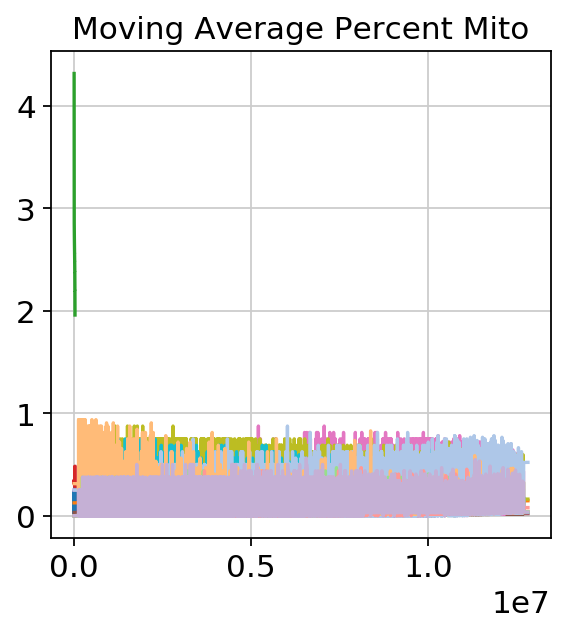

In [43]:
def moving_average(data,window_width):
    data_padded = np.pad(data, (window_width//2, window_width-1-window_width//2), mode='edge')
    cumsum_vec = np.cumsum(np.insert(data_padded, 0, 0)) 
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return(ma_vec)

plt.plot(range(doc_topic.shape[0]),np.std( doc_topic,axis=1))
plt.show()
plt.xlabel
#convolvedSD=np.convolve(np.std( doc_topic,axis=1), np.ones((300,))/300, mode='valid')
convolvedSD=moving_average(np.std( doc_topic,axis=1),500)
plt.plot(range(len(convolvedSD)),convolvedSD[::-1])
plt.title("Moving Average Sparsity (SD)")
plt.show()
plt.plot(range(adata.obs.shape[0]),np.sort(np.log10(adata.obs.n_counts))[::-1])
plt.title("Log Counts")
plt.show()
convolvedSD=moving_average(adata.obs['percent_ribo'][adata.obs.n_counts.argsort()[::-1]].tolist(),300)
plt.plot(range(len(convolvedSD)),convolvedSD)
plt.title("Moving Average Percent Ribo")
plt.show()
convolvedSD=moving_average(adata.obs['percent_mito'][adata.obs.n_counts.argsort()].tolist(),300)
plt.plot(range(len(convolvedSD)),convolvedSD[::-1])
plt.title("Moving Average Percent Mito")
plt.show()

#plt.savefig()
for i in range(doc_topic.shape[1]):
    #convolve solution is slow...
    #convolved=np.convolve(doc_topic[:,i], np.ones((300,))/300, mode='valid')
    convolved=moving_average(doc_topic[:,i],500)
    plt.plot(range(len(convolved)),convolved[::-1])
plt.show()


for i in range(doc_topic.shape[1]):
    #convolve solution is slow...
    #convolved=np.convolve(doc_topic[:,i], np.ones((300,))/300, mode='valid')
    convolved=pd.rolling_std(doc_topic[:,i],window=500)
    plt.plot(range(len(convolved)),convolved[::-1])
plt.show()


In [ ]:
sc.pp.neighbors(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


# PyMC3 Model

https://stackoverflow.com/questions/45092822/hierarchical-dirichlet-process-in-pymc3
https://stats.stackexchange.com/questions/104771/latent-dirichlet-allocation-in-pymc
https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d
https://github.com/napsternxg/ipython-notebooks/blob/master/PyMC_LDA.ipynb


In [31]:
tf.shape[1]

Subtensor{int64}.0

In [6]:
#https://discourse.pymc.io/t/lda-implementation-with-pymc3/1515/18
import pymc3 as pm, theano.tensor as t
from theano import shared

adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/orangutanorganoid_Pabe3_20180719_S10_Out/outs/raw_gene_bc_matrices_h5.h5','refdata-cellranger-Pabe3_20180719')
sc.pp.filter_genes(adata, min_cells=1000)
sc.pp.filter_cells(adata,min_counts=1000)
print(adata)

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf = adata.X
tf_feature_names = adata.var.index

# we have sparse dataset. It's better to have dense batch so that all words accure there
minibatch_size = 128

# defining minibatch
doc_t_minibatch = pm.Minibatch(tf.toarray(), minibatch_size)
doc_t = shared(tf.toarray()[:minibatch_size])
tf=doc_t_minibatch
print(doc_t_minibatch.shape)

K = 10 # number of topics
V = adata.shape[1] # number of words
no_features = adata.shape[0]

alpha = np.ones((1, K))
beta = np.ones((1, V))
model = pm.Model()
(D, W) = (minibatch_size,adata.shape[1])

print('Model Def')
with model: 
    thetas = pm.Dirichlet("thetas", a=alpha, shape=(D, K))
    phis = pm.Dirichlet("phis", a=beta, shape=(K, V))
    z = pm.Categorical("zx", p=thetas, shape=(W, D))
    w = pm.Categorical("wx", 
                       p=t.reshape(phis[z.T], (D*W, V)), 
                       observed=doc_t.reshape((D*W,)))
    
#pm.model_to_graphviz(model=model)
with model:    
    tr = pm.sample(100,chains = 1,exception_verbosity='high')
    pm.plots.traceplot(tr, ['thetas','phis']);


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
AnnData object with n_obs × n_vars = 569 × 1188 
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells'
Shape.0
Model Def


/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/pymc3/data.py:236: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Only 100 samples in chain.


Only 100 samples in chain.


Problem occurred during compilation with the command line below:
/usr/bin/g++ -shared -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -march=broadwell -mmmx -mno-3dnow -msse -msse2 -msse3 -mssse3 -mno-sse4a -mcx16 -msahf -mmovbe -maes -mno-sha -mpclmul -mpopcnt -mabm -mno-lwp -mfma -mno-fma4 -mno-xop -mbmi -mno-sgx -mbmi2 -mno-tbm -mavx -mavx2 -msse4.2 -msse4.1 -mlzcnt -mno-rtm -mno-hle -mrdrnd -mf16c -mfsgsbase -mrdseed -mprfchw -madx -mfxsr -mxsave -mxsaveopt -mno-avx512f -mno-avx512er -mno-avx512cd -mno-avx512pf -mno-prefetchwt1 -mno-clflushopt -mno-xsavec -mno-xsaves -mno-avx512dq -mno-avx512bw -mno-avx512vl -mno-avx512ifma -mno-avx512vbmi -mno-avx5124fmaps -mno-avx5124vnniw -mno-clwb -mno-mwaitx -mno-clzero -mno-pku -mno-rdpid --param l1-cache-size=32 --param l1-cache-line-size=64 --param l2-cache-size=3072 -mtune=broadwell -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -fPIC -I/home/mt/code/utils/miniconda3/lib/python3.6/site-packages/numpy/core

[Errno 12] Cannot allocate memory


OSError: [Errno 12] Cannot allocate memory

In [ ]:
## import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems
%env THEANO_FLAGS=device=cpu,floatX=float64
import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams


import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking

In [4]:
# The number of words in the vocaburary
n_words = 1000

print("Loading dataset...")
t0 = time()
dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words,
                                stop_words='english')

t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
feature_names = tf_vectorizer.get_feature_names()
print("done in %0.3fs." % (time() - t0))

In [5]:
n_samples_tr = 10000
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

AttributeError: module 'pymc3' has no attribute 'Container'

In [ ]:
def logp_lda_doc(beta, theta):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    """
    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log(theta[dixs]) + tt.log(beta.T[vixs]), axis=1).ravel()

        # Per-word log-likelihood times num of tokens in the whole dataset
        return tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens

    return ll_docs_f

In [ ]:
n_topics = 10
# we have sparse dataset. It's better to have dence batch so that all words accure there
minibatch_size = 128

# defining minibatch
doc_t_minibatch = pm.Minibatch(docs_tr.toarray(), minibatch_size)
doc_t = shared(docs_tr.toarray()[:minibatch_size])
with pm.Model() as model:
    theta = Dirichlet('theta', a=pm.floatX((1.0 / n_topics) * np.ones((minibatch_size, n_topics))),
                      shape=(minibatch_size, n_topics), transform=t_stick_breaking(1e-9),
                      # do not forget scaling
                      total_size=n_samples_tr)
    beta = Dirichlet('beta', a=pm.floatX((1.0 / n_topics) * np.ones((n_topics, n_words))),
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    # Note, that we devined likelihood with scaling, se here we need no additional `total_size` kwarg
    doc = pm.DensityDist('doc', logp_lda_doc(beta, theta), observed=doc_t)

In [ ]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [ ]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
local_RVs

In [ ]:
encoder_params = encoder.get_params()
encoder_params

In [ ]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
inference.fit(10000, callbacks=[reduce_rate], obj_optimizer=pm.sgd(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200,
              more_replacements={doc_t:doc_t_minibatch})